## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

### A note on variation of output

Note as always that due to the use of random numbers, some of the results here may differ from those in the book (since I re-ran everything to prepare this notebook), and will probably be different yet again if you run this notebook.

## Chapter 18: Autoencoders - Notebook 5: Denoising

In [1]:
# some code adapted from https://blog.keras.io/building-autoencoders-in-keras.html

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D, Conv2DTranspose
import h5py
import numpy as np
import matplotlib.pyplot as plt
#from pathlib import Path

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [ ]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
def get_mnist_samples():
    random_seed = 42
    np.random.seed(random_seed)

    # Read MNIST data. We won't be using the y_train or y_test data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    pixels_per_image = np.prod(X_train.shape[1:])

    # Cast values into the current floating-point type
    X_train = keras_backend.cast_to_floatx(X_train)
    X_test = keras_backend.cast_to_floatx(X_test)
    
    X_train = np.reshape(X_train, (len(X_train), 28, 28, 1)) 
    X_test = np.reshape(X_test, (len(X_test), 28, 28, 1)) 
    
    # Normalize the range from [0,255] to [0,1]
    X_train /= 255.
    X_test /= 255.

    return (X_train, X_test)

In [5]:
def add_noise_to_mnist(X_train, X_test, noise_factor=0.5): # add noise to the digita
    X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
    X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

    X_train_noisy = np.clip(X_train_noisy, 0., 1.)
    X_test_noisy = np.clip(X_test_noisy, 0., 1.)
    return (X_train_noisy, X_test_noisy)

In [13]:
def build_autoencoder1():
    # build the autoencoder.
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2,2,), padding='same'))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), padding='same'))
    # down to 7, 7, 32 now go back up
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(1, (3,3), activation='sigmoid', padding='same'))
    
    model.compile(optimizer='adadelta', loss='binary_crossentropy')
    return model

In [14]:
def build_autoencoder2():
    # build the autoencoder.
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', strides=2, input_shape=(28,28,1)))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', strides=2))
    # down to 7, 7, 32 now go back up
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(1, (3,3), activation='sigmoid', padding='same'))
    
    model.compile(optimizer='adadelta', loss='binary_crossentropy')
    return model

In [15]:
def build_autoencoder3():
    # build the autoencoder.
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', strides=2, input_shape=(28,28,1)))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', strides=2))
    # down to 7, 7, 32 now go back up
    model.add(Conv2DTranspose(32, (3,3), activation='relu', strides=2, padding='same'))
    model.add(Conv2DTranspose(32, (3,3), activation='relu', strides=2, padding='same'))
    model.add(Conv2D(1, (3,3), activation='sigmoid', padding='same'))
    
    model.compile(optimizer='adadelta', loss='binary_crossentropy')
    return model

In [16]:
def functional_api_build_autoencoder():
    # build the autoencoder.
    input_img = Input(shape=(28, 28, 1))  # using `channels_last` image data format

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    model.compile(optimizer='adadelta', loss='binary_crossentropy')
    return model

In [17]:
(X_train, X_test) = get_mnist_samples()
(X_train_noisy, X_test_noisy) = add_noise_to_mnist(X_train, X_test, 0.5)

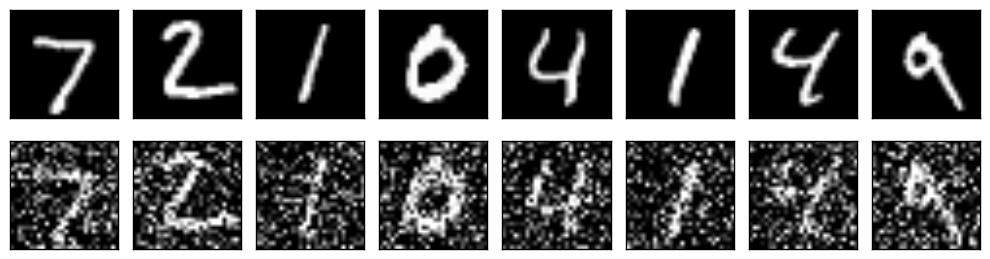

In [18]:
plt.figure(figsize=(10,3))
for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.subplot(2, 8, i+1+8)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    plt.xticks([], [])
    plt.yticks([], [])
plt.tight_layout()
file_helper.save_figure("NB5-AE-noisy-mnist-input")
plt.show()

In [19]:
model1 = build_autoencoder1()
weights_filename = "NB5-Denoising-AE1"
np.random.seed(42)
if not file_helper.load_model_weights(model1, weights_filename):
    history1 = model1.fit(X_train_noisy, X_train,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test_noisy, X_test))
    file_helper.save_model_weights(model1, weights_filename)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 97s - loss: 0.1940 - val_loss: 0.1285
Epoch 2/100
60000/60000 [==============================] - 98s - loss: 0.1231 - val_loss: 0.1166
Epoch 3/100
60000/60000 [==============================] - 95s - loss: 0.1145 - val_loss: 0.1105
Epoch 4/100
60000/60000 [==============================] - 91s - loss: 0.1101 - val_loss: 0.1068
Epoch 5/100
60000/60000 [==============================] - 91s - loss: 0.1073 - val_loss: 0.1066
Epoch 6/100
60000/60000 [==============================] - 91s - loss: 0.1056 - val_loss: 0.1040
Epoch 7/100
60000/60000 [==============================] - 92s - loss: 0.1042 - val_loss: 0.1031
Epoch 8/100
60000/60000 [==============================] - 92s - loss: 0.1032 - val_loss: 0.1015
Epoch 9/100
60000/60000 [==============================] - 92s - loss: 0.1025 - val_loss: 0.1018
Epoch 10/100
60000/60000 [==============================] - 92s - loss: 0.101

In [20]:
model2 = build_autoencoder2()
weights_filename = "NB5-Denoising-AE2"
np.random.seed(42)
if not file_helper.load_model_weights(model2, weights_filename):
    history2 = model2.fit(X_train_noisy, X_train,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test_noisy, X_test))
    file_helper.save_model_weights(model2, weights_filename)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 74s - loss: 0.1861 - val_loss: 0.1228
Epoch 2/100
60000/60000 [==============================] - 73s - loss: 0.1189 - val_loss: 0.1129
Epoch 3/100
60000/60000 [==============================] - 73s - loss: 0.1121 - val_loss: 0.1085
Epoch 4/100
60000/60000 [==============================] - 73s - loss: 0.1085 - val_loss: 0.1060
Epoch 5/100
60000/60000 [==============================] - 74s - loss: 0.1064 - val_loss: 0.1047
Epoch 6/100
60000/60000 [==============================] - 74s - loss: 0.1050 - val_loss: 0.1030
Epoch 7/100
60000/60000 [==============================] - 74s - loss: 0.1038 - val_loss: 0.1026
Epoch 8/100
60000/60000 [==============================] - 75s - loss: 0.1029 - val_loss: 0.1018
Epoch 9/100
60000/60000 [==============================] - 73s - loss: 0.1021 - val_loss: 0.1011
Epoch 10/100
60000/60000 [==============================] - 72s - loss: 0.101

In [21]:
model3 = build_autoencoder3()
weights_filename = "NB5-Denoising-AE3"
np.random.seed(42)
if not file_helper.load_model_weights(model3, weights_filename):
    history3 = model3.fit(X_train_noisy, X_train,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test_noisy, X_test))
    file_helper.save_model_weights(model3, weights_filename)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 90s - loss: 0.1956 - val_loss: 0.1206
Epoch 2/100
60000/60000 [==============================] - 85s - loss: 0.1159 - val_loss: 0.1106
Epoch 3/100
60000/60000 [==============================] - 79s - loss: 0.1107 - val_loss: 0.1083
Epoch 4/100
60000/60000 [==============================] - 76s - loss: 0.1084 - val_loss: 0.1071
Epoch 5/100
60000/60000 [==============================] - 75s - loss: 0.1071 - val_loss: 0.1063
Epoch 6/100
60000/60000 [==============================] - 75s - loss: 0.1061 - val_loss: 0.1045
Epoch 7/100
60000/60000 [==============================] - 77s - loss: 0.1052 - val_loss: 0.1046
Epoch 8/100
60000/60000 [==============================] - 77s - loss: 0.1045 - val_loss: 0.1036
Epoch 9/100
60000/60000 [==============================] - 75s - loss: 0.1040 - val_loss: 0.1023
Epoch 10/100
60000/60000 [==============================] - 75s - loss: 0.103

In [26]:
def draw_noisy_predictions_set(predictions, filename=None):
    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test_noisy[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i+6)
        plt.imshow(predictions[i,:,:,0].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure(filename+'-predictions')
    plt.show()

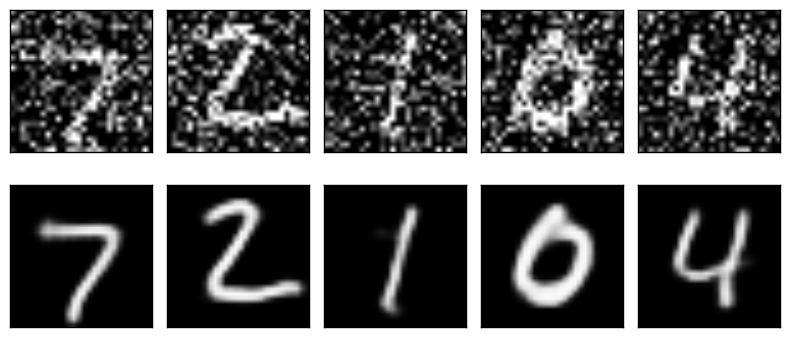

In [28]:
predictions1 = model1.predict(X_test_noisy)
draw_noisy_predictions_set(predictions1, 'NB5-Noisy-Model1')

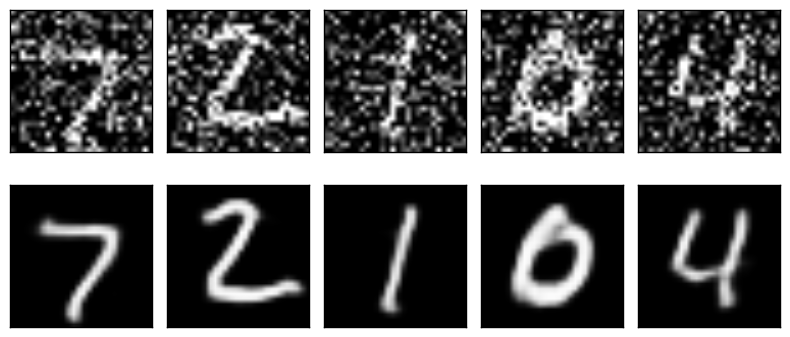

In [29]:
predictions2 = model2.predict(X_test_noisy)
draw_noisy_predictions_set(predictions2, 'NB5-Noisy-Model2')

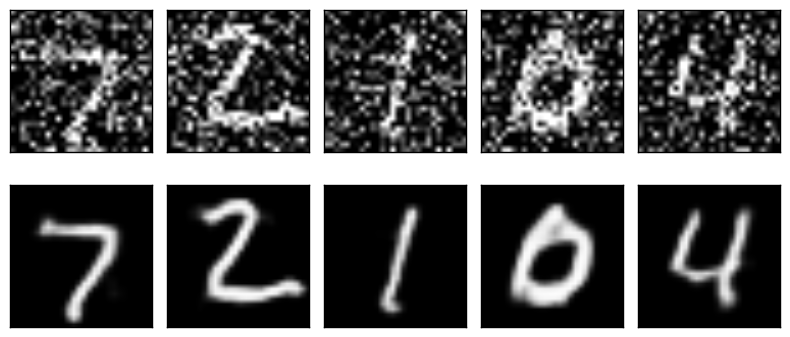

In [30]:
predictions3 = model3.predict(X_test_noisy)
draw_noisy_predictions_set(predictions3, 'NB5-Noisy-Model3')